# Dive into JAX by implementing old school ML algos
# degan 05/17/23

In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, vmap
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
KEY = random.PRNGKey(42)
N_SAMPLES = 100

# Data setup
_Note_ We could in the future take advantage of `sklearn.datasets`'s `make_regression` and `train_test_split`

In [3]:
def generate_data(n: int) -> tuple:
    x = jnp.expand_dims(jnp.arange(n), -1)

    rando_noise = random.uniform(KEY, (n,1), minval=-10, maxval=20)
    y = 3.14 * x + rando_noise

    return x, y

x, y = generate_data(N_SAMPLES)
x.shape, y.shape

((100, 1), (100, 1))

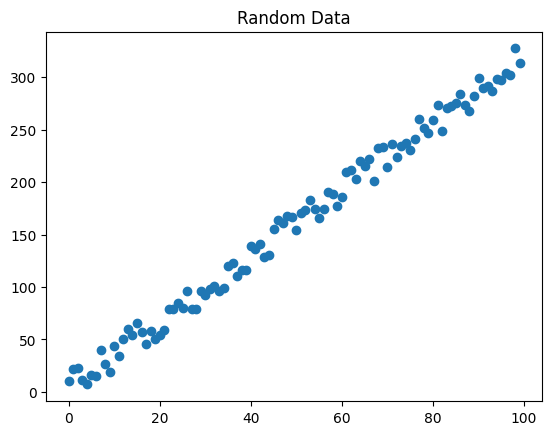

In [4]:
# Sanity check!
plt.title("Random Data")
plt.scatter(x=x, y=y);

In [5]:
idxs = random.permutation(KEY, jnp.arange(N_SAMPLES), independent=True)

x = x[idxs]
y = y[idxs]

idxs

Array([85, 83, 30, 66, 79, 59, 76,  7, 20, 19, 74, 77, 22, 38, 50, 93, 71,
       21, 55, 99, 53, 78, 64, 84, 65, 61, 23, 57, 90,  0, 88, 14,  8, 29,
       10, 26, 54, 48, 42, 94, 24, 67, 56, 95, 31,  6, 27,  1, 46, 63, 18,
       72,  5, 69, 80, 44, 40, 13, 34,  3, 25, 32, 89, 16, 75, 36, 17, 37,
       82, 62, 86, 58, 15,  2, 97, 33, 68,  9, 12, 96, 49, 70, 92, 11, 43,
        4, 81, 87, 51, 91, 47, 60, 98, 45, 52, 73, 41, 35, 39, 28],      dtype=int32)

In [6]:
train_pct = 0.7
test_pct  = 0.15
val_pct   = 0.15

assert train_pct + test_pct + val_pct == 1.

In [7]:
train_start = 0
train_end   = int(train_pct * N_SAMPLES)

val_start = train_end
val_end   = int((train_pct + val_pct) * N_SAMPLES)

test_start = val_end

In [8]:
x_train = x[train_start:train_end]
y_train = y[train_start:train_end]

x_val = x[val_start:val_end]
y_val = y[val_start:val_end]

x_test = x[val_end:]
y_test = y[val_end:]

### Standardize data

In [9]:
def standardize(x, mean, std):
    return (x - mean) / std

In [10]:
# We are not allowed to peak at val/test so use train  for mean / std
x_mean, x_std = jnp.mean(x_train), jnp.std(x_train)
y_mean, y_std = jnp.mean(y_train), jnp.std(y_train)

x_train = standardize(x_train, x_mean, x_std)
x_val   = standardize(x_val, x_mean, x_std)
x_test  = standardize(x_test, x_mean, x_std)

y_train = standardize(y_train, y_mean, y_std)
y_val   = standardize(y_val, y_mean, y_std)
y_test  = standardize(y_test, y_mean, y_std)

In [11]:
x_train.shape, y_train.shape

((70, 1), (70, 1))

# Model and train

In [21]:
class LinearRegression:

    def __init__(self, input_dim: int, output_dim: int):
        self.params = {
            'w': random.normal(KEY, (input_dim, output_dim)),
            'b': jnp.zeros((input_dim, output_dim))
        }

        # By calling JIT we go from 244ms +/- 26ms to 3.63ms +/- 1.32ms nice
        self.forward  = jax.jit(lambda params, x: jnp.dot(x, params['w']) + params['b'])
        self.mse_loss = jax.jit(lambda params, x, y: jnp.mean(jnp.square(y - self.forward(params, x))))
        self.grad_fn  = jax.jit(grad(self.mse_loss))

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def step(self, x, y, debug: bool = False):

        b_w, b_b = self.params['w'], self.params['b']
        self.params = jax.tree_map(lambda p, g: p - 0.05 * g, self.params, self.grad_fn(self.params, x, y))

        if debug:
            print(f"Params before: {b_w} {b_b}\n"
                  f"Params after : {self.params}")

In [22]:
lr = LinearRegression(x_train.shape[1], y_train.shape[1])

In [23]:
%%timeit
for _ in range(50):
    loss = lr.mse_loss(lr.params, x_val, y_val)
    lr.step(x_train, y_train)

3.76 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
pred_test = lr.params['w'] * x_test + lr.params['b']
plt.plot(x_test, pred_test)
plt.scatter(x_test, y_test)

NameError: name 'lr' is not defined